In [2]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from model import ImagePredictor
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RAdam
from tqdm import tqdm
import cv2

from utils import data

BATCH_SIZE = 240
LR = 0.07876825335509738
EPOCHS = 20

device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

In [4]:
def get_datasets(device, use_n3: bool = False):

    def create_dataset(data, idxs):
        dataset = []

        for sequence in data:
            for idx in idxs:
                dataset.append(sequence[idx])

        dataset = np.array(dataset)
        return dataset[:, :-1], dataset[:, -1]

    def denoise(img):
        img = np.uint8(img * 255)
        img = cv2.fastNlMeansDenoising(img, h=10)
        return img / 255.0

    ds = data.Datasets("/Users/henrywilliams/Documents/uni/amml/assessment/data")
    if not use_n3:
        sequences = ds.n6_full().numpy()
    else:
        sequences = ds.n3_full().numpy()

    sequences = (sequences - sequences.min()) / (sequences.max() - sequences.min())
    idxs = np.array([[i + j for j in range(3)] for i in range(14)])

    train_mask = np.isin(idxs, data.TEST_INDICIES)
    test_mask = np.isin(idxs[:, -1], data.TEST_INDICIES)
    train_idxs = idxs[~train_mask.any(axis=1)]
    test_idxs = idxs[test_mask]

    train_X, train_y = create_dataset(sequences, train_idxs)
    test_X, test_y = create_dataset(sequences, test_idxs)

    # train_X = np.array([[denoise(xi) for xi in x] for x in train_X])
    train_y = np.array([denoise(y) for y in train_y])
    # test_X = np.array([[denoise(xi) for xi in x] for x in test_X])
    test_y = np.array([denoise(y) for y in test_y])

    train_y = train_y.reshape(-1, 1, 36, 36, 1)
    test_y = test_y.reshape(-1, 1, 36, 36, 1)

    train_X = torch.tensor(train_X, dtype=torch.float32, device=device).permute(
        0, 4, 1, 2, 3
    )
    train_y = torch.tensor(train_y, dtype=torch.float32, device=device).permute(
        0, 4, 1, 2, 3
    )
    test_X = torch.tensor(test_X, dtype=torch.float32, device=device).permute(
        0, 4, 1, 2, 3
    )
    test_y = torch.tensor(test_y, dtype=torch.float32, device=device).permute(
        0, 4, 1, 2, 3
    )

    train = TensorDataset(train_X, train_y)
    test = TensorDataset(test_X, test_y)

    train_loader = DataLoader(train, BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test, BATCH_SIZE, shuffle=True)

    return train_loader, test_loader


train_loader, test_loader = get_datasets(device, use_n3=True)
torch.save(train_loader, "n3_train_loader.pt")
torch.save(test_loader, "n3_test_loader.pt")

In [6]:
test_loader.dataset

In [3]:
model = ImagePredictor(
    in_channels=1,
    num_kernels=61,
    num_layers=4,
    kernel_size=(3, 3),
    padding=(1, 1),
    activation="tanh",
    image_size=(36, 36),
    device=device,
).to(device)

optim = RAdam(model.parameters(), lr=LR)

criterion = nn.MSELoss()

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    for input, target in tqdm(
        train_loader,
        desc=f"Train epoch {epoch + 1}/{EPOCHS}",
        leave=False,
        postfix=f"Test Loss: {test_losses[-1]:.2f}" if epoch != 0 else "",
    ):
        output = model(input).unsqueeze(1)
        loss = criterion(output, target)
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_losses.append(loss.item())

    test_loss = 0
    model.eval()
    for input, target in tqdm(
        test_loader,
        desc=f"Test epoch {epoch + 1}/{EPOCHS}",
        leave=False,
    ):
        with torch.no_grad():
            output = model(input).unsqueeze(1)
        loss = criterion(output, target)
        test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
torch.save(model.state_dict(), "best-convlstm.pt")

In [10]:
print(test_losses[-1])

4.917709447909146e-06

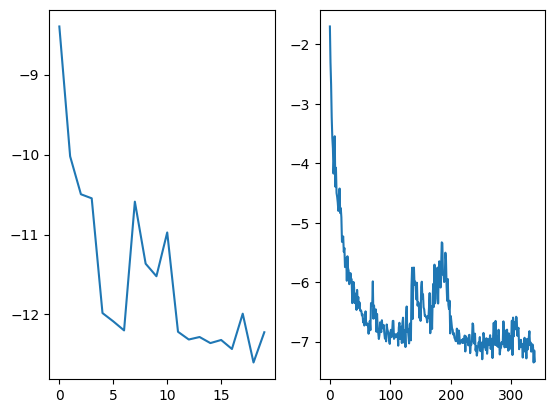

In [12]:
plt.subplot(1, 2, 1)
plt.plot(np.log(test_losses))
plt.subplot(1, 2, 2)
plt.plot(np.log(train_losses))

tensor(0.7059, device='mps:0') tensor(0.0627, device='mps:0')

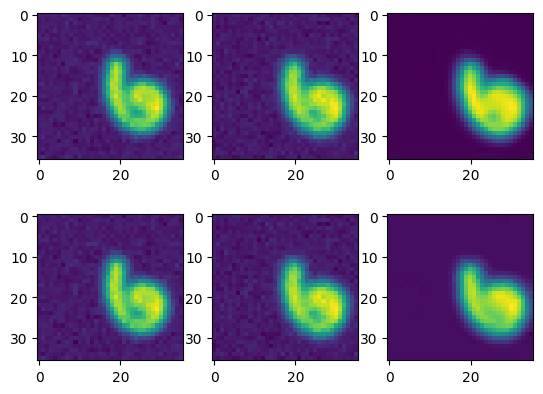

In [30]:
test_idxs = np.random.choice(len(test_loader.dataset))
test_X, test_y = test_loader.dataset[test_idxs]
y_pred = model(test_X.unsqueeze(0))

print(test_y.max(), test_y.min())

plt.subplot(2, 3, 1)
plt.imshow(test_X[0, 0].cpu())
plt.subplot(2, 3, 2)
plt.imshow(test_X[0, 1].cpu())
plt.subplot(2, 3, 3)
plt.imshow(y_pred.cpu().detach().squeeze(0).reshape(36, 36))
plt.subplot(2, 3, 4)
plt.imshow(test_X[0, 0].cpu())
plt.subplot(2, 3, 5)
plt.imshow(test_X[0, 1].cpu())
plt.subplot(2, 3, 6)
plt.imshow(test_y[0].cpu().reshape(36, 36))
plt.show()

# plt.imshow((test_y[test_idxs, 0].cpu() - y_pred.cpu().detach()).abs().reshape(36, 36))

In [7]:
n3_loader = get_datasets(device, use_n3=True)

In [8]:
model.eval()
total_test = len(n3_loader[0].dataset) + len(n3_loader[1].dataset)
n3_loss = 0.0

loop = tqdm(total=total_test, desc="Testing on n3")
for loader in n3_loader:
    for input, target in loader:
        with torch.no_grad():
            output = model(input).unsqueeze(1)
        n3_loss += criterion(output, target)
        loop.update(len(input))

n3_loss /= total_test

print(f"Average Loss on N3: {n3_loss}")

Testing on n3: 100%|██████████| 1200/1200 [00:03<00:00, 403.10it/s]

Average Loss on N3: 5.021374363423092e-06

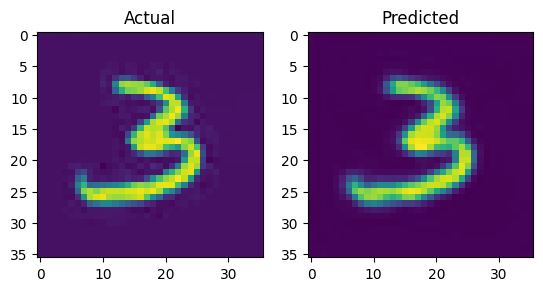

In [23]:
idx = np.random.choice(len(output))
y_hat = output[idx].cpu().detach()
y = target[idx].cpu().detach()

plt.subplot(1, 2, 1)
plt.title("Actual")
plt.imshow(y.reshape(36, 36))
plt.subplot(1, 2, 2)
plt.title("Predicted")
plt.imshow(y_hat.reshape(36, 36))